### Vehicle Detection Project -- Tracking Part

Zikri Bayraktar, Ph.D.

This project has two parts:
1. Train a classifier to identify cars on an image of a road.
2. Create a pipeline to detect vehicles in a video stream.

Below, I am using ensemble of models to come up with a consensus among all to decide which part of the camera image contains cars so that we can track it.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
from collections import deque

%matplotlib inline

In [2]:
# LECTURE FUNCTIONS -- USEFUL

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1.0)):
    #print(img)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    #print(hist_features)
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [3]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [4]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 255), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #print(max(features))
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #print(test_features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(imgIN, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(imgIN, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return imgIN

### LOAD MULTIPLE MODELS FOR THE ENSEMBLE

I trained multiple models with different color spaces.  Combine their predictions in an ensemble to find a consensus.

In [6]:
# Load a model from a pickle file:
with open('model_RGB_hist_range.pickle', 'rb') as handle:
    svc_RGB = pickle.load(handle)

# Load the scalar from training:
with open('scalar_RGB_hist_range.pickle', 'rb') as handle:
    X_scaler_RGB = pickle.load(handle)

#--------------------------------------------------------
# Load a model from a pickle file:
with open('model_HLS_hist_range.pickle', 'rb') as handle:
    svc_HLS = pickle.load(handle)

# Load the scalar from training:
with open('scalar_HLS_hist_range.pickle', 'rb') as handle:
    X_scaler_HLS = pickle.load(handle)

#--------------------------------------------------------
# Load a model from a pickle file:
with open('model_HSV_hist_range.pickle', 'rb') as handle:
    svc_HSV = pickle.load(handle)

# Load the scalar from training:
with open('scalar_HSV_hist_range.pickle', 'rb') as handle:
    X_scaler_HSV = pickle.load(handle)

#--------------------------------------------------------
# Load a model from a pickle file:
with open('model_YCrCb_hist_range.pickle', 'rb') as handle:
    svc_YCrCb = pickle.load(handle)

# Load the scalar from training:
with open('scalar_YCrCb_hist_range.pickle', 'rb') as handle:
    X_scaler_YCrCb = pickle.load(handle)

#--------------------------------------------------------
# Load a model from a pickle file:
with open('model_YUV_hist_range.pickle', 'rb') as handle:
    svc_YUV = pickle.load(handle)

# Load the scalar from training:
with open('scalar_YUV_hist_range.pickle', 'rb') as handle:
    X_scaler_YUV = pickle.load(handle)


In [7]:
ensemble_of_models = {}
#ensemble_of_models['RGB'] = svc_RGB
#ensemble_of_models['HLS'] = svc_HLS
#ensemble_of_models['HSV'] = svc_HSV
ensemble_of_models['YCrCb'] = svc_YCrCb
ensemble_of_models['YUV'] = svc_YUV

ensemble_of_scalers = {}
#ensemble_of_scalers['RGB'] = X_scaler_RGB
#ensemble_of_scalers['HLS'] = X_scaler_HLS
#ensemble_of_scalers['HSV'] = X_scaler_HSV
ensemble_of_scalers['YCrCb'] = X_scaler_YCrCb
ensemble_of_scalers['YUV'] = X_scaler_YUV

In [8]:
orientations = {}
#orientations['RGB'] = 18
#orientations['HLS'] = 16
#orientations['HSV'] = 9
orientations['YCrCb'] = 32
orientations['YUV'] = 16

spatials = {}
#spatials['RGB'] = 16
#spatials['HLS'] = 16
#spatials['HSV'] = 16
spatials['YCrCb'] = 32
spatials['YUV'] = 16

wws = {}
#wws['RGB'] = [128,64]
#wws['HLS'] = [128,64]
#wws['HSV'] = [128,64]
wws['YCrCb'] = [48,64,96,128]
wws['YUV'] = [48,64,96,128]

# use different y_ranges for different window sizes, i.e. far, middle, near ranges
y_ss = [[400, 496], [428, 556], [450, 642], [400, 668]]  # Min and max in y to search in slide_window()

In [9]:
# Make sure these parameters are consistent with the values when the classifier trained:
#color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 16  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
#spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [380, 690] # Min and max in y to search in slide_window()
#y_start_stop = [428, 556] #580] # Min and max in y to search in slide_window()


# use this to track car heatmaps over multiple frames in video.
n_frames = 5
consensus = deque(maxlen = n_frames) #You can choose how many frames to use.

## Define Pipeline

In [11]:
def pipeline(image):
    # JPEG images are in (0,255) but model trained on PNG in range (0,1)
    window_img = np.copy(image)
    image = image.astype(np.float32)/255
    
    # Consensus is among all models to decide which pixels contains cars:
    #consensus = np.zeros_like(image[:,:,0]).astype(np.float)
    # this is per model, for various window sizes:
    hot_windows_all = {'RGB':[], 'HSV':[], 'HLS':[], 'YCrCb':[], 'YUV':[]   }

    # Loop through each model, get the predictions and come up a consensus (among the ensemble):
    for (Cspace, svc), (a, X_scaler), (b,orient), (c,spt) in zip(ensemble_of_models.items(), ensemble_of_scalers.items(), 
                                                             orientations.items(), spatials.items()):
        #print(Cspace)
        # each model has different window sizes to search:
        i=0
        for xyw in wws[Cspace]:
            #print(xyw, i, y_ss[i])
            windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_ss[i], 
                                    xy_window=(xyw, xyw), xy_overlap=(0.75, 0.75))
            
            hot_windows = search_windows(image, windows, svc, X_scaler, color_space=Cspace, 
                            spatial_size=(spt,spt), hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

            # record all hot windows per model type:
            hot_windows_all[Cspace] = hot_windows_all[Cspace] + hot_windows
            i=i+1
            
        # Create heatmap
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,hot_windows_all[Cspace])
        # Apply threshold to help remove false positives
        #heat = apply_threshold(heat,2)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        #heat[heat>3.0]=1
        #consensus = consensus + heat
        consensus.append(heatmap)
        
        #print(np.amax(heat))
        
        #fig = plt.figure()
        #plt.imshow(heat) #, cmap='gray')

    # Once we have all pixel values voted, threshold it at 2, i.e. 2 models out of 3 says that pixel is a car:
    #consensus[consensus < 1.0]=0
    #consensus[consensus >= 1.0]=1  #3 votes out of 5
    #print(np.amax(consensus))
    #print('----------------')
    
    combined = sum(consensus)
    final_heat = apply_threshold(combined, 5)
    labels = label(final_heat) #label(consensus)
    
    #fig = plt.figure()
    #plt.imshow(combined)
    
    #print(window_img)

    draw_img = draw_labeled_bboxes(window_img, labels)
    
    #print(draw_img.shape)
    return draw_img
    

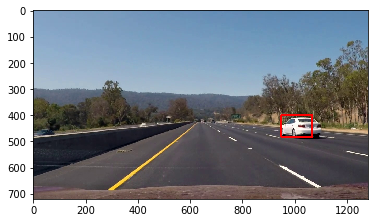

In [13]:
### TESTING:
#images = glob.glob('split_frames/frame1030.jpg')
images = glob.glob('split_frames/frame385.jpg')

#images=['split_frames/frame10.jpg', 'split_frames/frame11.jpg', 'split_frames/frame12.jpg', 'split_frames/frame13.jpg',
#        'split_frames/frame14.jpg', 'split_frames/frame15.jpg', 'split_frames/frame16.jpg', 'split_frames/frame17.jpg',
#        'split_frames/frame18.jpg', 'split_frames/frame19.jpg']

#images=['split_frames/frame1030.jpg', 'split_frames/frame1031.jpg', 'split_frames/frame1032.jpg', 'split_frames/frame1033.jpg',
#        'split_frames/frame1034.jpg', 'split_frames/frame1035.jpg', 'split_frames/frame1036.jpg', 'split_frames/frame1037.jpg',
#        'split_frames/frame1038.jpg', 'split_frames/frame1039.jpg']

#images=['split_frames/frame640.jpg', 'split_frames/frame641.jpg', 'split_frames/frame642.jpg', 'split_frames/frame643.jpg',
#        'split_frames/frame644.jpg', 'split_frames/frame645.jpg', 'split_frames/frame646.jpg', 'split_frames/frame647.jpg',
#        'split_frames/frame648.jpg', 'split_frames/frame649.jpg']

#images=['split_frames/frame380.jpg', 'split_frames/frame381.jpg', 'split_frames/frame382.jpg', 'split_frames/frame383.jpg',
#        'split_frames/frame384.jpg', 'split_frames/frame385.jpg', 'split_frames/frame386.jpg', 'split_frames/frame387.jpg',
#        'split_frames/frame388.jpg', 'split_frames/frame389.jpg']



for fname in images:
    #print(fname)
    image = mpimg.imread(fname)
    lbs = pipeline(image)

    fig = plt.figure()
    plt.imshow(lbs)

In [56]:
### TESTING

#testIN = mpimg.imread('folder_vehicles/GTI_Left/image0010.png')

#z = bin_spatial(testimg)
#z = color_hist(testimg)

#testimg = cv2.cvtColor(testIN, cv2.COLOR_RGB2YCrCb)

#_, z1 = get_hog_features(testimg[:,:,0], orient=16, pix_per_cell=16, cell_per_block=2, vis=True)
#_, z2 = get_hog_features(testimg[:,:,1], orient=16, pix_per_cell=16, cell_per_block=2, vis=True)
#_, z3 = get_hog_features(testimg[:,:,2], orient=16, pix_per_cell=16, cell_per_block=2, vis=True)

#fig = plt.figure()
#plt.subplot(141)
#plt.imshow(testimg)
#plt.title('Original')
#plt.subplot(142)
#plt.imshow(z1, cmap='gray')
#plt.title('Channel 1')
#plt.subplot(143)
#plt.imshow(z2, cmap='gray')
#plt.title('Channel 2')
#plt.subplot(144)
#plt.imshow(z3, cmap='gray')
#plt.title('Channel 3')
#fig.tight_layout()


In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
white_output = 'examples/zprojectV.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(37,39)
clip1 = VideoFileClip("project_video.mp4") #.subclip(41,42)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video examples/zprojectV.mp4
[MoviePy] Writing video examples/zprojectV.mp4


100%|█████████▉| 1260/1261 [5:15:48<00:15, 15.09s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: examples/zprojectV.mp4 

CPU times: user 5h 15min 38s, sys: 9.7 s, total: 5h 15min 48s
Wall time: 5h 15min 48s
